# Petermann 3D Basin Model

Use icepack diagnostic/prognostic solve and hybrid model features to create a steady-state Petermann 3D model
- Takes friction coefficient value from PetermannBasin_Friction 
- Takes temperature field from PetermannBasin_HeatTransport

## Setup

In [1]:
import sys 
import glob
import os

import matplotlib.pyplot as plt
import numpy as np

import rioxarray as rxr
import xarray as xr
import rasterio

import geojson

import firedrake
import icepack
import icepack.plot

fatal: detected dubious ownership in repository at '/mnt/data01/Code/OtherRepos/firedrake/src/PyOP2'
To add an exception for this directory, call:

	git config --global --add safe.directory /mnt/data01/Code/OtherRepos/firedrake/src/PyOP2
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


### Mesh

In [4]:
outline_fn = 'petermann_streamlines_evenspace_full.geojson'
fn=outline_fn.split('.')[0]

with open(outline_fn, 'r') as outline_file:
    outline = geojson.load(outline_file)

In [ ]:
if os.path.isfile(fn+'.msh'):
    pass
else:
    geometry = icepack.meshing.collection_to_geo(outline)

    with open('petermann_streamline_evenspace_full.geo', 'w') as geo_file:
        geo_file.write(geometry.get_code())
        
    !gmsh -2 -format msh2 -v 2 -o petermann_streamline_evenspace_full.msh petermann_streamline_evenspace_full.geo;

In [5]:
mesh2d = firedrake.Mesh(fn+'.msh')
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

### Load/Interpolate Raster Data

In [2]:
### Reading data
root_ddir = '/mnt/data01/Data/'
thesis_dir = '/mnt/data01/User_Scratch/wdienstfrey24/Thesis/'

velocity_fn = glob.glob(root_ddir+'Greenland_Velocity/*.nc')
ice_info_fn = glob.glob(root_ddir+'Greenland_BedElevation/*.nc')[0]
hillshade_fn = glob.glob(root_ddir+'Greenland_Imagery/*.nc') 
hs = xr.open_dataset(hillshade_fn[0])
geothermal_fn = glob.glob(root_ddir+'Greenland_OtherData/Martos*.nc')
surftemp_fn = glob.glob(root_ddir+'Greenland_OtherData/SeaRise_surf*.nc')
racmo_fn = glob.glob(thesis_dir+'Petermann-HeatFlow/*average.nc')

vx = rxr.open_rasterio(velocity_fn[0])[0,:,:]
vy = rxr.open_rasterio(velocity_fn[1])[0,:,:]
vz=vy.copy()
vz.values=np.zeros(np.shape(vy.values))
speed=np.sqrt(vx**2+vy**2)

ice_bed_props = rxr.open_rasterio(ice_info_fn)
thickness = ice_bed_props['thickness'][0,:,:]
bed = ice_bed_props['bed'][0,:,:]
surface = ice_bed_props['surface'][0,:,:]

geothermal = xr.open_rasterio(geothermal_fn[0])[0,:,:]/1000
racmo = xr.open_dataset(racmo_fn[0])
surftemp = racmo['T2m_avg']
SMB = racmo['SMB_avg']

In [6]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='R', vdegree=0)
V = firedrake.VectorFunctionSpace(mesh, family='CG', dim=2, degree=2, vfamily='GL', vdegree=2)

h0 = icepack.interpolate_xr(thickness, Q)
s0 = icepack.interpolate_xr(surface, Q)
b = icepack.interpolate_xr(bed, Q)
u0 = icepack.interpolate_xr((vx, vy), V)

#q = firedrake.FunctionSpace(mesh2d, family='CG', degree=2)
#v = firedrake.VectorFunctionSpace(mesh2d, family='CG', degree=2)

#h0_2d = icepack.interpolate_xr(thickness, q)
#s0_2d = icepack.interpolate_xr(surface, q)
#b_2d = icepack.interpolate_xr(bed, q)
#u0_2d = icepack.interpolate_xr((vx, vy), v)

### Plotting Functions

In [7]:
def subplots(*args, **kwargs):
    zoom = kwargs.get("zoom",0)
    figsize = kwargs.get("figsize",(8,8))
    
    fig, ax = plt.subplots(figsize=figsize)
    im1=ax.imshow(hs['hillshade'].values,
                  extent=[hs['x'].values.min(),hs['x'].values.max(),hs['y'].values.min(),hs['y'].values.max()],
                  cmap='Greys_r', vmin=0,vmax=200,origin='upper')
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))    
    
    if zoom == -1:
        ax.set_ylim([-1.6e6,-1e6]);
        ax.set_xlim([-0.325e6,0.1e6]);
    elif zoom == 0:
        ax.set_ylim([-1.55e6,-.9e6]);
        ax.set_xlim([-0.3e6,0.05e6]);
    elif zoom == 1:
        ax.set_ylim(-1.1e6,-0.9e6);
        ax.set_xlim(-3e5,-1.5e5);

    ax.set_aspect('equal')
    
    return fig, ax

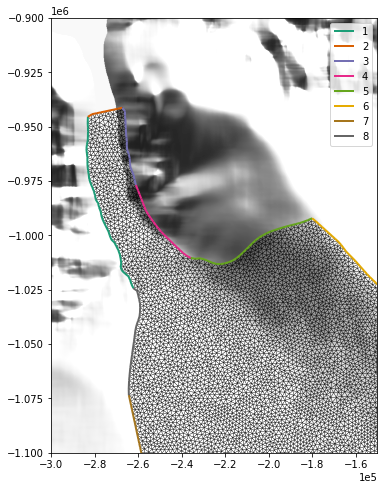

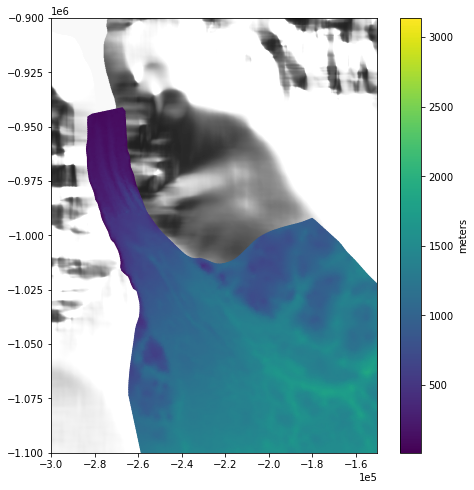

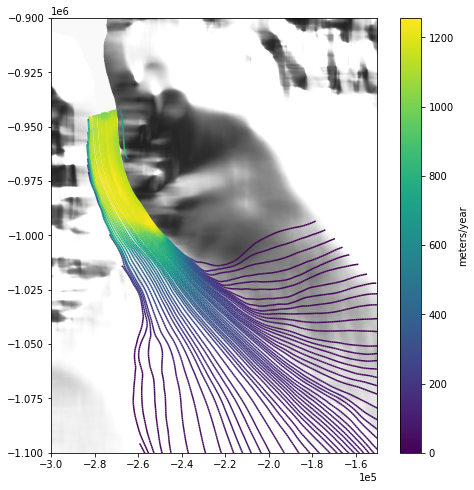

In [8]:
fig,ax = subplots(zoom=1)
kwargs = {
    'interior_kw': {'linewidth': .25},
    'boundary_kw': {'linewidth': 2}
}
icepack.plot.triplot(mesh2d, axes=ax, **kwargs);
ax.legend();

fig,ax = subplots(zoom=1)
colors = icepack.plot.tripcolor(h0, axes=ax)
fig.colorbar(colors, label='meters');

fig, ax = subplots(zoom=1)
streamlines = icepack.plot.streamplot(u0, precision=1e3, density=4e3, axes=ax)
fig.colorbar(streamlines, label='meters/year');

## Modeling

### Friction

Text(0.5, 1.0, 'Friction Coefficient')

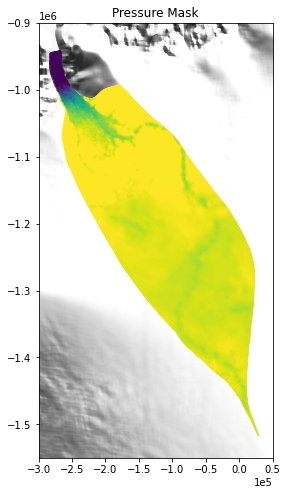

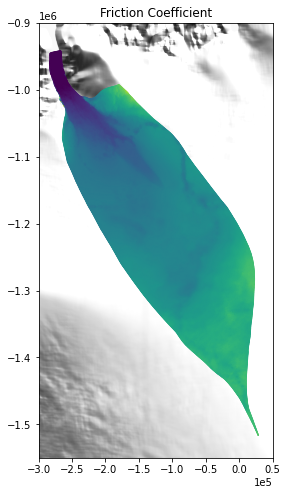

In [9]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m
)
from firedrake import Constant, sqrt, inner, grad, dx
import os

### Import friction parameterization (derived in PetermannBasin_Friction)
C=firedrake.Function(Q)


filename = 'Petermann_basin_friction'
if os.path.isfile(filename+'.h5'):
    with firedrake.DumbCheckpoint(filename, "r") as chk:
        chk.load(C, name="friction")
else:
    α = Constant(10e3)
    τ = firedrake.Function(V)
    τ_d = -ρ_I * g * h0 *firedrake.as_vector([grad(s0)[0],grad(s0)[1]])
    misfit = 0.5 * inner(τ - τ_d, τ - τ_d) * dx
    smoothness = 0.5 * α ** 2 * inner(grad(τ), grad(τ)) * dx
    J = misfit + smoothness
    F = firedrake.derivative(J, τ)
    firedrake.solve(F == 0, τ)

    p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
    p_I = ρ_I * g * h0
    ϕ = 1 - p_W / p_I
    C_est = sqrt(inner(τ, τ)) / sqrt(inner(u0, u0))
    fraction = Constant(0.5)

    expr = ϕ * fraction * C_est ** (1 / m)

    C = firedrake.interpolate(expr, Q)
    #area = firedrake.assemble(Constant(1.0) * dx(mesh))
    #C_0 = Constant(firedrake.assemble(C_0 * dx) / area)

pw = firedrake.interpolate(ϕ,Q)
fig1,ax1 = subplots()
colors1 = icepack.plot.tripcolor(icepack.depth_average(pw), axes=ax1)
fig.colorbar(colors1);
ax1.set_title("Pressure Mask")
    
fig2,ax2 = subplots()
colors2 = icepack.plot.tripcolor(C, axes=ax2)
fig.colorbar(colors2);
ax2.set_title("Friction Coefficient")

In [10]:
import icepack.models.hybrid
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    year as year,
    gravity as g
)

def friction(**kwargs):
    u = kwargs['velocity']
    h = kwargs['thickness']
    s = kwargs['surface']
    C = kwargs['friction']
    
    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    
    C = C * ϕ
    return icepack.models.friction.bed_friction(velocity=u, friction=C)

### Temperature

In [11]:
T = firedrake.Constant(255.0)
A = icepack.rate_factor(T)

### Accumulation rate

In [12]:
a = firedrake.Constant(0)

### Model/Solver

In [13]:
model = icepack.models.HybridModel(friction=friction)
degree = 4
opts = {
    "dirichlet_ids": [5,6,7,8],
    "side_wall_ids": [1,3,4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    "form_compiler_parameters": {
        "quadrature_degree": degree
    }
}
solver = icepack.solvers.FlowSolver(model, **opts)

In [14]:
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h0,
    surface=s0,
    fluidity=A,
    friction=C
)

In [15]:
import tqdm

num_years = 400
timesteps_per_year = 1

δt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

us=[]
hs=[]
ss=[]

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        δt,
        thickness=h,
        velocity=u,
        accumulation=a,
        thickness_inflow=h0
    )
    s = icepack.compute_surface(thickness=h, bed=b)
    
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
        friction=C
    )
    us.append(u)
    hs.append(h)
    ss.append(s)

  0%|          | 0/400 [03:19<?, ?it/s]


ConvergenceError: Nonlinear solve failed to converge after 9 nonlinear iterations.
Reason:
   DIVERGED_INNER

## Analysis

In [ ]:
import NDH_Tools as ndh

In [39]:
def glacier_z_coords(var, h, s, b, field, xsampling=100, zsampling=10):
    ################# Here, we produce the x and ζ coordinates to extract
    x_opts = np.linspace(0.001,Lx-0.001,xsampling)
    ζ_opts = np.linspace(0.001,0.999,zsampling)
    x_coords_grid,ζ_coords_grid=np.meshgrid(x_opts,ζ_opts)

    orig_size = x_coords_grid.shape
    x_coords_vec = np.reshape(x_coords_grid,[1,np.prod(orig_size)])
    ζ_coords_vec = np.reshape(ζ_coords_grid,[1,np.prod(orig_size)])

    ################# Combine the x and ζ 1D arrays to get an n x 2 array containing all the points we want to extract
    coord_list = np.concatenate([x_coords_vec,ζ_coords_vec]).T

    ################# Here we loop through the list of coordinates and extract the points at relevant values 
    ################# (Firedrake can probably do this without a loop, but I started testing things this way)
    var_extract = []

    for i in coord_list:
        var_extract.append(var.at(i[0],i[1]))

    ################# We turn that into a numpy array, and then we turn it into the shape of the original meshgrids
    var_extract_vec = np.array(var_extract)
    var_extract_grid = np.reshape(var_extract,orig_size)

    ################# Here we create an array of the ice surface elevation values
    surf = np.array(icepack.depth_average(s).at(x_opts))
    ################# Here we create an array of the ice surface elevation values
    bed = np.array(icepack.depth_average(b).at(x_opts))
    ################# And then the ice bed elevation values -- What does the Q do here? I just copied Wills code that worked.
    ice_base = firedrake.interpolate(s - h, field)
    ice_base = np.array(icepack.depth_average(ice_base).at(x_opts))

    ################# Then, using a bit of matrix algebra, we create a (1) matrix of relative thickness positions corresponding to the 
    ################# ζ values, and then we add it to a matrix of the bed elevation values (made to be the same size as the original z mesh grid)
    ################# This produces a matrix, the same size at the x_coords_grid, with corresponding true z for the glacier
    z_coords_grid = np.matmul(np.matrix(ζ_opts).T,np.matrix(surf-ice_base))+np.tile(ice_base,(zsampling,1))
    
    return(var_extract_grid, surf, bed, ice_base, x_opts, x_coords_grid, z_coords_grid)

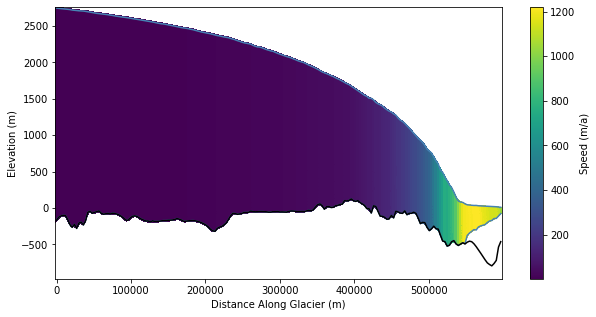

In [40]:
def glacier_plot(u, h, s, b, field, xsampling=200, zsampling=100):
    (u_extract_grid, surf, bed, ice_b, x_opts, x_coords_grid, z_coords_grid) = glacier_z_coords(u, h, s, b, field, xsampling, zsampling)
    
    fig, ax = plt.subplots(figsize=(10,5))

    cdata = plt.pcolor(x_coords_grid,z_coords_grid,u_extract_grid)
    cbar = plt.colorbar(cdata,label='Speed (m/a)')
    plt.plot(x_opts,surf,c='steelblue')
    plt.plot(x_opts,ice_b,c='steelblue')
    plt.plot(x_opts,bed,c='black')

    plt.xlabel('Distance Along Glacier (m)')
    plt.ylabel('Elevation (m)')
    return fig, ax
initial_glacier=glacier_plot(u0,h0,s0,b,V)

After Generating the Writer, include the following:
Outside the loop:      with writer.saving(fig, videoname, 100):
To capture a frame:    writer.grab_frame()


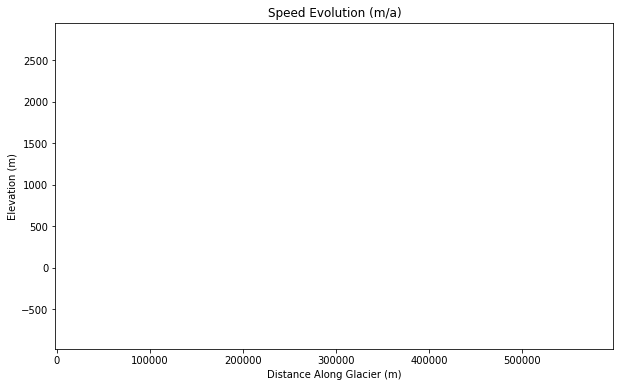

In [22]:
writer = ndh.generate_animation(5,'Slices')
videoname1 = 'Evolution_speed.mp4'

fig, axes = plt.subplots(figsize=(10,6))
axes.set_xlabel('Distance Along Glacier (m)')
axes.set_ylabel('Elevation (m)')
axes.set_title('Speed Evolution (m/a)')
with writer.saving(fig, videoname1, 100):
    for i,u in enumerate(us[::5]):
        (u_extract_grid, surf, bed, ice_b, x_opts, x_coords_grid, z_coords_grid) = glacier_z_coords(u, hs[i], ss[i], b, V,xsampling=200,zsampling=100)

        cdata = axes.pcolor(x_coords_grid,z_coords_grid,u_extract_grid)
        cbar = plt.colorbar(cdata,label='Speed (m/a)')

        l1=axes.plot(x_opts,surf,c='steelblue')
        l2=axes.plot(x_opts,ice_b,c='steelblue')
        l3=axes.plot(x_opts,bed,c='black')

        writer.grab_frame()
        
        cbar.remove()
        l1.pop(0).remove()
        l2.pop(0).remove()
        l3.pop(0).remove()
        cdata.remove();

In [23]:
ndh.show_video('Evolution_speed.mp4')